In [5]:
%matplotlib inline

from deepsea import *
from keras.models import load_model

from IntegratedGradients import integrated_gradients

import seaborn as sns
import matplotlib.pyplot as plt

from math import ceil

import os

In [2]:
dsmodel = load_model("models/deepsea/weights-improvement-09-0.06-full.hdf5")

In [3]:
dsmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [4]:
valid_X, valid_Y, train_X, train_Y, test_X, test_Y = loaddata("data/deepsea/")

# Explaining DeepSEA predictions

In [6]:
def extract_max_window(matrix, size=20, step=5):
    _max = 0
    _max_window = None
    for i in range(0, matrix.shape[1]-size, step):
        window = matrix[:, i:i+size]
        if np.sum(window) > _max:
            _max = np.sum(window)
            _max_window = window
    return _max_window

In [7]:
# Getting the list of output features.
description = [i.split("\t")[2] + "_in_" + i.split("\t")[1] for i in open("data/deepsea/features.txt").readlines()[1:-1]]

In [8]:
#Generating predictions
prediction = dsmodel.predict(valid_X)

In [11]:
def visualize_explanations(TFindex, description, prediction, ifshow=False):
    path = "figures/explanations/shap_true_positives_"+description[TFindex]+".png"
    if os.path.isfile(path) and not ifshow:
        return False
    
    ig = integrated_gradients(dsmodel, [TFindex], verbose=0)
    indexes = [i for i in range(len(valid_Y[:,TFindex])) if valid_Y[:,TFindex][i] == 1 and prediction[:, TFindex][i] > 0.5]
    
    wsize = 40
    column = 3
    scale = 0.1
    
    plt.figure(figsize=(scale*wsize*column,4*scale*ceil(len(indexes)*1.0/column)))
    plt.suptitle(description[TFindex], fontsize=15)

    count = 0
    for index in indexes:
        plt.subplot(ceil(len(indexes)*1.0/column), column, count+1)
        #Look at explanation for 200 bps in the central region.
        ex = ig.explain(valid_X[index])[0][400:600,:]
        ex = np.transpose(ex)

        #Ignore negative Shapley
        ex[ex < 0] = 0

        #Extract 30 bp subwindow with highst explanation weight
        window = extract_max_window(ex, size=wsize)

        #Plot
        plt.bar(range(wsize), window[0,:], color="blue", width=1, linewidth=0, alpha=0.7)
        plt.bar(range(wsize), window[1,:], bottom=window[0,:], color="red", width=1, linewidth=0, alpha=0.7)
        plt.bar(range(wsize), window[2,:], bottom=window[0,:]+window[1,:], color="green", width=1, linewidth=0, alpha=0.7)
        plt.bar(range(wsize), window[3,:], bottom=window[0,:]+window[1,:]+window[2,:], color="yellow", width=1, linewidth=0, alpha=0.7)
        plt.yticks([],[])
        plt.xticks([],[])
        plt.ylim(0,0.2)

        count += 1

    if ifshow:
        plt.show()
    else:
        plt.savefig(path)
        plt.close()

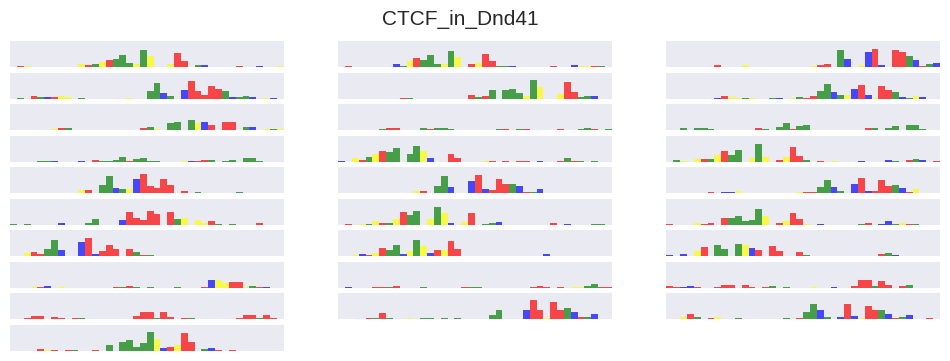

In [12]:
#Generating for the first input as a sample.
visualize_explanations(0, description, prediction, ifshow=True)

In [13]:
#Generating it for all outputs!
for i in range(1):
    try:
        visualize_explanations(i, description, prediction)
    except:
        pass

# Clusting explanations to identify motifs.

This needs to be implemented